# Dealing with long-range interactions

## Background

The Coulomb interactions in materials that are at least partly ionic give rise to long-range contributions to the forces and allows the system to sustain a finite dielectric displacement in the long-wavelength limit ($\vec{q}\rightarrow \vec{0}$).
This effect gives rise to a splitting of the longitudinal optical (LO) and transverse optical (TO) modes for $\vec{q}\rightarrow \vec{0}$ that varies with the direction of approach (i.e. the direction of the momentum vector $\vec{q}$).
To obtain the correct LO-TO splitting one commonly applies a so-called non-analytic term correction (NAC; see [Gonze *et al.* (1994)](#GonChaAll94) and [Gonze and Lee (1997)](#GonLee97)), which requires knowledge of the Born effective charges (BECs) $\mathcal{Z}_{\alpha\beta}$ and the dielectric constant $\varepsilon_{\alpha\beta}$, both of which are in general tensorial quantities.
The NAC can be handled, e.g., by [**phonopy**](https://phonopy.github.io/phonopy/formulation.html#non-analytical-term-correction-theory).

The long-range nature of the ionic interactions also poses a challenge when constructing force constant expansions (FCEs).
In such cases one typically observes a slow and often non-monotonic convergence of the FCE with system size that in many cases renders it near impossible to obtain converged results.
To circumvent this problem, one can separate the force constants into a long-ranged (Coulomb) and a short-ranged part, where the former contribution can be calculated using the same quantities as the NAC, namely the BECs and the dielectric constant.

In practice, one (1) substracts the forces from the Coulomb interaction (screened by the dielectric tensor) from the reference forces, (2) trains a (short-ranged) FCE to the remaining (short-ranged) forces, and (3) adds back the long-range contributions to the force constants.
The thus-obtained force constants can then be used, e.g., to compute the phonon dispersion, the calculation of which should include the NAC.

This effects described above as well as the correction procedure are demonstrated for the case of sodium chloride (NaCl) below.

In [1]:
import numpy as np
from ase import Atoms
from ase.io import read
from hiphive import ClusterSpace, StructureContainer, ForceConstantPotential
from trainstation import Optimizer
from hiphive.utilities import prepare_structures
from matplotlib import pyplot as plt
from phonopy import Phonopy
from phonopy.file_IO import parse_BORN

## Non-analytic term correction

To begin with we consider a standard **phonopy** calculation with and without NAC to illustrate the impact on the phonon dispersion.
First we set up a phonopy object with a set of force constants.

In [2]:
# Set up phonopy object
unitcell = read('NaCl_unitcell.xyz')
phonon = Phonopy(unitcell,
                 np.diag([4, 4, 4]),
                 primitive_matrix=[[0, 0.5, 0.5],
                                   [0.5, 0, 0.5],
                                   [0.5, 0.5, 0]])
# The following call generates the displacement dataset.
phonon.generate_displacements()

# In this example we already have a set of forces precalculated,
# which we load and use to set up the force constants.
displaced_supercells_with_forces = read('supercells_with_forces.xyz', index=':')
forces = [supercell.get_forces() for supercell in displaced_supercells_with_forces]
phonon.set_forces(forces)
phonon.produce_force_constants()

Next we compute the phonon dispersion a long a certain Brillouin zone path that will be reused below.

In [3]:
path_labels = ['G', 'X', 'K', '$\Gamma$','L']
path = [
    np.linspace([0.0, 0.0, 0.0], [0.5, 0.0, 0.0]),
    np.linspace([0.5, 0.0, 0.0], [0.5, 0.5, 0.0]),
    np.linspace([0.5, 0.5, 0.0], [0.0, 0.0, 0.0]),
    np.linspace([0.0, 0.0, 0.0], [0.5, 0.5, 0.5])]
phonon.set_band_structure(path)
dispersion_phonopy_without_NAC = phonon.get_band_structure_dict()

Now we add the NAC using parameters read from a file (`BORN`) and recompute the dispersion.
Please consult the [**phonopy** documentation](https://phonopy.github.io/phonopy/input-files.html#born-optional) for a description of this file.
Note that can also provide the BECs and the dielectric constant [directly via **phonopy**'s Python API](https://phonopy.github.io/phonopy/phonopy-module.html#non-analytical-term-correction).

In [4]:
phonon.nac_params = parse_BORN(phonon.primitive, filename='BORN')
phonon.set_band_structure(path)  # Force recalculation of dispersion
dispersion_phonopy_with_NAC = phonon.get_band_structure_dict()

Finally, we plot the two dispersions.

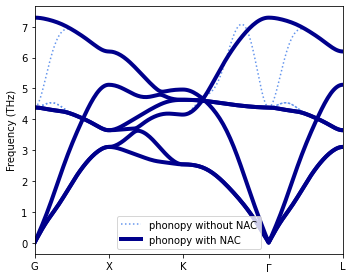

In [5]:
fig, ax = plt.subplots(figsize=(5, 4))

# Plot dispersion without NAC
lines = ax.plot(np.hstack(dispersion_phonopy_without_NAC['distances']),
                np.vstack(dispersion_phonopy_without_NAC['frequencies']),
                c='cornflowerblue', linestyle='dotted')
lines[0].set_label('phonopy without NAC')

# Plot dispersion with NAC
lines = ax.plot(np.hstack(dispersion_phonopy_with_NAC['distances']),
                np.vstack(dispersion_phonopy_with_NAC['frequencies']),
                c='darkblue', linestyle='solid', lw=4)
lines[0].set_label('phonopy with NAC')

# Show q-point labels on x-axis
xticks = {}
for k, (dist, lbl) in enumerate(zip(dispersion_phonopy_with_NAC['distances'], path_labels)):
    xticks[dist[0]] = lbl
xticks[dist[-1]] = path_labels[-1]
xpts = list(xticks.keys())
ax.set_xlim(xpts[0], xpts[-1])
ax.set_xticks(xpts)
ax.set_xticklabels(xticks.values())

# Other settings
ax.set_ylabel('Frequency (THz)')
ax.legend()

plt.tight_layout()

## FC extraction with long-range corrections

We now proceed to extract the FCs by regression via **hiphive**.
Here, we use the same structures as for the "pure" **phonopy** analysis above, in which only one atom is displaced per structure.
Even though, in general, in the regression approach one would use structures with more general displacement patterns.

In [6]:
cutoff = 11.0
cs = ClusterSpace(unitcell, [cutoff])
sc = StructureContainer(cs)

supercell_ph = phonon.get_supercell()
supercell = Atoms(cell=supercell_ph.cell,
                  positions=supercell_ph.positions,
                  numbers=supercell_ph.numbers,
                  pbc=True)
for structure in prepare_structures(displaced_supercells_with_forces, supercell):
    sc.add_structure(structure)

Primitive cell:
    Formula: ClNa
    Cell:
        [  0.00000   2.84515   2.84515]
        [  2.84515   0.00000   2.84515]
        [  2.84515   2.84515   0.00000]
    Basis:
        Na  [  0.00000   0.00000   0.00000]
        Cl  [  0.50000   0.50000   0.50000]

Crystal symmetry:
    Spacegroup:          Fm-3m (225)
    Unique site:         2
    Symmetry operations: 48
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 11.0
    Found 2 center atoms with 334 images totaling 336 atoms

Clusters:
    Clusters: {2: 501}
    Total number of clusters: 501

Orbits:
    Orbits: {2: 23}
    Total number of orbits: 23

Eigentensors:
    Eigentensors: {2: 76}
    Total number of parameters: 76

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 74}
    Total number of degrees of freedom: 74
Done in 0d 0h 0m 10.5s
Done in 0d 0h 0m 3.24s
Done in 0d 0h 0m 0.267s


First we apply the approach directly without special consideration of long-range (Coulomb) forces.

In [7]:
# Train parameters by regression
opt = Optimizer(sc.get_fit_data())
opt.train()
fcp = ForceConstantPotential(cs, opt.parameters)

# Extract second-order FCs for the given supercell
fc2 = fcp.get_force_constants(supercell).get_fc_array(order=2)
phonon.set_force_constants(fc2)
phonon.set_band_structure(path)
dispersion_hiphive_without_LRC = phonon.get_band_structure_dict()

Done in 0d 0h 0m 10.3s


The results ("hiphive with NAC but without LRC") reveal "oscillations" in the optical branches in the approach to $\Gamma$, i.e. $\vec{q}\rightarrow\vec{0}$.

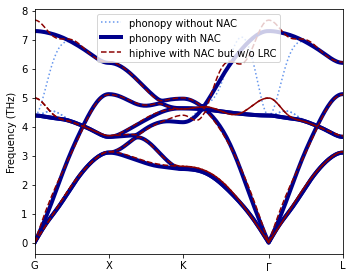

In [8]:
fig, ax = plt.subplots(figsize=(5, 4))

# Plot dispersion from phonopy without NAC
lines = ax.plot(np.hstack(dispersion_phonopy_without_NAC['distances']),
                np.vstack(dispersion_phonopy_without_NAC['frequencies']),
                c='cornflowerblue', linestyle='dotted')
lines[0].set_label('phonopy without NAC')

# Plot dispersion from phonopy with NAC
lines = ax.plot(np.hstack(dispersion_phonopy_with_NAC['distances']),
                np.vstack(dispersion_phonopy_with_NAC['frequencies']),
                c='darkblue', linestyle='solid', lw=4)
lines[0].set_label('phonopy with NAC')

# Plot dispersion from hiphive with NAC but without LRC
lines = ax.plot(np.hstack(dispersion_hiphive_without_LRC['distances']),
                np.vstack(dispersion_hiphive_without_LRC['frequencies']),
                c='darkred', linestyle='dashed')
lines[0].set_label('hiphive with NAC but w/o LRC')

# Other settings
ax.set_xlim(xpts[0], xpts[-1])
ax.set_xticks(xpts)
ax.set_xticklabels(xticks.values())
ax.set_ylabel('Frequency (THz)')
ax.legend()

plt.tight_layout()

Now we repeat the regression approach but this time we remove the long-range (Coulomb) forces before training the short-ranged FCs and then add the long and short-ranged contributions to the second-order FCs before evaluating the phonon dispersion. For computing the contribution of the long-range forces to the second-order FCs, we use functionality from **phonopy**.

In [9]:
# Obtain the long-range (Coulomb) contribution to the second-order FCs
phonon.set_force_constants(np.zeros((len(supercell), len(supercell), 3, 3)))
dynmat = phonon.get_dynamical_matrix()
dynmat.make_Gonze_nac_dataset()
fc2_LR = -dynmat.get_Gonze_nac_dataset()[0]

# Remove the corresponding forces from the training data
displacements = np.array([fs.displacements for fs in sc])
M, F = sc.get_fit_data()
F -= np.einsum('ijab,njb->nia', -fc2_LR, displacements).flatten()

# ... and fit the remaining forces to a regular FC expansion
opt = Optimizer((M, F))
opt.train()
fcp = ForceConstantPotential(cs, opt.parameters)
fc2_SR = fcp.get_force_constants(supercell).get_fc_array(order=2)

# Finally, we add the two contributions to the second-order FCs and compute the band structure
phonon.set_force_constants(fc2_SR + fc2_LR)
phonon.set_band_structure(path)
dispersion_hiphive_with_LRC = phonon.get_band_structure_dict()

Done in 0d 0h 0m 10.6s


The resulting phonon dispersion ("hiphive with NAC and LRC") is in excellent agreement with the reference dispersion from **phonopy**.

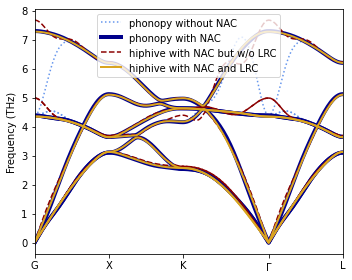

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))

# Plot dispersion from phonopy without NAC
lines = ax.plot(np.hstack(dispersion_phonopy_without_NAC['distances']),
                np.vstack(dispersion_phonopy_without_NAC['frequencies']),
                c='cornflowerblue', linestyle='dotted')
lines[0].set_label('phonopy without NAC')

# Plot dispersion from phonopy with NAC
lines = ax.plot(np.hstack(dispersion_phonopy_with_NAC['distances']),
                np.vstack(dispersion_phonopy_with_NAC['frequencies']),
                c='darkblue', linestyle='solid', lw=4)
lines[0].set_label('phonopy with NAC')

# Plot dispersion from hiphive with NAC but without LRC
lines = ax.plot(np.hstack(dispersion_hiphive_without_LRC['distances']),
                np.vstack(dispersion_hiphive_without_LRC['frequencies']),
                c='darkred', linestyle='dashed')
lines[0].set_label('hiphive with NAC but w/o LRC')

# Plot dispersion from hiphive with NAC and LRC
lines = ax.plot(np.hstack(dispersion_hiphive_with_LRC['distances']),
                np.vstack(dispersion_hiphive_with_LRC['frequencies']),
                c='goldenrod', linestyle='solid', lw=2)
lines[0].set_label('hiphive with NAC and LRC')

# Other settings
ax.set_xlim(xpts[0], xpts[-1])
ax.set_xticks(xpts)
ax.set_xticklabels(xticks.values())
ax.set_ylabel('Frequency (THz)')
ax.legend()

plt.tight_layout()

## References

* <a name="GonChaAll94">X. Gonze, J.-C. Charlier, D.C. Allan, and M.P. Teter</a>,
   *Interatomic force constants from first principles: The case of α-quartz*,
   [Physical Review B **50**, 13035(R) (1994)](https://doi.org/10.1103/PhysRevB.50.13035)

* <a name="GonLee97">X. Gonze and C. Lee</a>,
  *Dynamical matrices, Born effective charges, dielectric permittivity tensors, and interatomic force constants from density-functional perturbation theory*,
  [Physical Review B **55**, 10355 (1997)](https://doi.org/10.1103/PhysRevB.55.10355)</font>